Pipeline tutorial
=================

This tutorial will walk you through the basic usage of the `lib5c` pipeline.

Follow along in Google colab
-----------------

You can run and modify the cells in this notebook tutorial live using Google colaboratory by clicking the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thomasgilgenast/lib5c-tutorials/blob/master/pipeline_tutorial.ipynb)

To simply have all the cells run automatically, click `Runtime > Run all` in the colab toolbar.

Make sure `lib5c` is installed
------------------------------

Inside a fresh virtual environment, run

In [1]:
!pip install -q lib5c
!lib5c -v

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


lib5c version 0.5.4


Make a directory
----------------

Create a directory for this pipeline and change into it

```
$ mkdir lib5c-tutorial
$ cd lib5c-tutorial
```


Get data
--------

First, download some data from GEO. For this tutorial, we will use the 5C data
set from [GEO Series GSE68582](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE68582).

The specific files we will need are:

* A [primerfile](http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE68582&format=file&file=GSE68582%5FBED%5FES%2DNPC%2DiPS%2DLOCI%5Fmm9%2Ebed%2Egz)
  describing the fragments in the 5C assay.
* Four raw countsfiles containing the results of two replicates each of two
  conditions (v65 and pNPC):

  * [v65 Rep 1](http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1974095&format=file&file=GSM1974095%5Fv65%5FRep1%2Ecounts%2Etxt%2Egz)
  * [v65 Rep 2](http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1974096&format=file&file=GSM1974096%5Fv65%5FRep2%2Ecounts%2Etxt%2Egz)
  * [pNPC Rep 1](http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1974099&format=file&file=GSM1974099%5FpNPC%5FRep1%2Ecounts%2Etxt%2Egz)
  * [pNPC Rep 2](http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1974100&format=file&file=GSM1974100%5FpNPC%5FRep2%2Ecounts%2Etxt%2Egz)

Download the five files using the links above, then unzip them into a new
directory, `lib5c-tutorial/input`. Finally, strip all of the `.txt`
extensions and GEO identifiers for brevity. If you use the `bash` shell, you
can do all of this by running the following commands:

In [2]:
!mkdir -p input
!wget -qO- 'http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE68582&format=file&file=GSE68582%5FBED%5FES%2DNPC%2DiPS%2DLOCI%5Fmm9%2Ebed%2Egz' \
    | gunzip -c > input/BED_ES-NPC-iPS-LOCI_mm9.bed
!wget -qO- 'http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1974095&format=file&file=GSM1974095%5Fv65%5FRep1%2Ecounts%2Etxt%2Egz' \
    | gunzip -c > input/v65_Rep1.counts
!wget -qO- 'http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1974096&format=file&file=GSM1974096%5Fv65%5FRep2%2Ecounts%2Etxt%2Egz' \
    | gunzip -c > input/v65_Rep2.counts
!wget -qO- 'http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1974099&format=file&file=GSM1974099%5FpNPC%5FRep1%2Ecounts%2Etxt%2Egz' \
    | gunzip -c > input/pNPC_Rep1.counts
!wget -qO- 'http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1974100&format=file&file=GSM1974100%5FpNPC%5FRep2%2Ecounts%2Etxt%2Egz' \
    | gunzip -c > input/pNPC_Rep2.counts
!sed -i '/Sox2\|Klf4/!d' input/BED_ES-NPC-iPS-LOCI_mm9.bed

or you can download, unzip, and rename them manually. After renaming, the
``lib5c-tutorial/input`` directory should contain the following files:

* ``BED_ES-NPC-iPS-LOCI_mm9.bed``
* ``v65_Rep1.counts``
* ``v65_Rep2.counts``
* ``pNPC_Rep1.counts``
* ``pNPC_Rep2.counts``

Note for Docker image users
---------------------------

If you are using `lib5c` from the Docker image, run

    $ docker run -it -v <full path to lib5c-tutorial>:/lib5c-tutorial creminslab/lib5c:latest
    root@<container_id>:/# cd /lib5c-tutorial

and continue running all tutorial commands in this shell.

Get the default config file
---------------------------

From inside `lib5c-tutorial`, run `lib5c pipeline` to drop the example
pipeline configuration file, `luigi.cfg`.

In [3]:
!lib5c pipeline

no luigi.cfg found in current directory
dropping example luigi.cfg file...


The behavior of the entire pipeline is controlled using this one configuration
file.

Edit the config file
--------------------

Open `luigi.cfg` in your favorite text editor and take a look inside.

The config file is organized into blocks that start with a header and then
define some config variables.

The first block is the `[PipelineTask]` block, which lists the pipelines to be
run in a list called `tasks`, the entries of which look like directories.
These are in fact the directory structures into which the outputs will be
written. The folder names in the directory path correspond to individual steps
of the pipeline, as described in the `table` mapping, which has the general
format

    "folder_name": ["step_name", {non_default_parameters}]

The same step can be defined with different parameters, as long as the output
folder names are distinguishable; for example, the section

    ...
    "bin_gmean_16_4": ["MakeBinned", {}],
    "bin_amean_20_8": ["MakeBinned", {"window_function": "amean",
                                      "bin_width": 8000,
                                      "window_width": 20000}],
    ...

shows two different parameter choices for the binning step.

The second block is the `[RawCounts]` block, which specifies where the input
countsfiles are located on the disk and gives them replicate names.

The third block is the `[PrimerFile]` block, which specifies where to find the
primerfile on the disk.

The remaining sections expose the default parameters for each step (e.g.,
`[MakeBinned]` describes the default binning step parameters).

For this tutorial, you can leave the `[PipelineTask]` block unchanged.

However, we need to fill in the `[RawCounts]` and `[PrimerFile]` blocks
with the paths to the data files we downloaded. For example:

    [RawCounts]
    countsfiles={
      "ES_Rep1": "input/v65_Rep1.counts",
      "ES_Rep2": "input/v65_Rep2.counts",
      "pNPC_Rep1": "input/pNPC_Rep1.counts",
      "pNPC_Rep2": "input/pNPC_Rep2.counts"
      }

    [PrimerFile]
    primerfile=input/BED_ES-NPC-iPS-LOCI_mm9.bed

The config parser is somewhat sensitive to indentation, so match this carefully.

The replicate names are the keys of the `countsfiles` dictionary. You can set
them to anything you like; however, the "conditions" (for the purposes of
classifying condition-specific interactions) as defined in the `conditions`
comma-separated list under the `[MakeThreshold]` block near the bottom of the
config file must be substrings of the replicate names. For convenience, by
default `conditions=ES,pNPC` which matches the replicate names we have chosen
above, but when you do your own analyses you may need to change this.

In [4]:
!sed -i 's/"rep1": "path\/to\/rep1.counts",/"ES_Rep1": "input\/v65_Rep1.counts",\n  "ES_Rep2": "input\/v65_Rep2.counts",/g' luigi.cfg
!sed -i 's/"rep2": "path\/to\/rep2.counts"/"pNPC_Rep1": "input\/pNPC_Rep1.counts",\n  "pNPC_Rep2": "input\/pNPC_Rep2.counts"/g' luigi.cfg
!sed -i 's/path\/to\/primerfile.bed/input\/BED_ES-NPC-iPS-LOCI_mm9.bed/g' luigi.cfg

Just to make the notebook run faster, we'll disable some of the automatic plot generation, focus on just two regions, and use a larger bin size

In [5]:
!sed -i '/plot_outfile=%d\/expected-plots\/%s_%r.png/d' luigi.cfg
!sed -i 'N;s/outfile_pattern=%s_qnorm.counts\nheatmap=True/outfile_pattern=%s_qnorm.counts\nheatmap=False/g' luigi.cfg
!sed -i 'N;s/outfile_pattern=%s_express.counts\nheatmap=True/outfile_pattern=%s_express.counts\nheatmap=False/g' luigi.cfg
!sed -i 's/\/bin_gmean_16_4\//\/bin_gmean_20_8\//g' luigi.cfg
!sed -i '/Sox2\|Klf4/!d' input/BED_ES-NPC-iPS-LOCI_mm9.bed

After specifying the input files, save the config file, then run

In [6]:
!lib5c pipeline

creating directory ./raw


lib5c plot heatmap -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -R ./raw/ES_Rep2_raw.counts ./raw/ES_Rep2_raw_%r.png


loading counts


preparing to plot


plotting


lib5c plot heatmap -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -R ./raw/pNPC_Rep1_raw.counts ./raw/pNPC_Rep1_raw_%r.png


loading counts


preparing to plot


plotting


lib5c plot heatmap -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -R ./raw/ES_Rep1_raw.counts ./raw/ES_Rep1_raw_%r.png


loading counts


preparing to plot


plotting


lib5c plot heatmap -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -R ./raw/pNPC_Rep2_raw.counts ./raw/pNPC_Rep2_raw_%r.png


loading counts


preparing to plot


plotting


lib5c qnorm -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -R ./raw/qnormed/%s_qnorm.counts ./raw/pNPC_Rep2_raw.counts ./raw/ES_Rep2_raw.counts ./raw/ES_Rep1_raw.counts ./raw/pNPC_Rep1_raw.counts


loading counts


quantile normalizing


writing counts


lib5c express -J -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -B './raw/qnormed/*_qnorm.counts' ./raw/qnormed/jointexpress/%s_express.counts


loading counts


precomputing expected models


joint express normalizing


writing counts


writing bias vectors


lib5c bin -b bedfiles/8kb_bins.bed -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -f gmean -w 20000 -t 0.0 -W ./raw/qnormed/jointexpress/pNPC_Rep1_express.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep1_binned.counts


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep1_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep1_binned_%r.png


loading counts


preparing to plot


plotting
encountered exception, falling back to series operation


lib5c expected -p bedfiles/8kb_bins.bed -d 1 -f 0.8 -w 15 -x 5 -m 0.2 -e 0.1 -t auto -M -E -D -O -X ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep1_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/pNPC_Rep1_expected.counts


loading counts


defaulting to logged empirical binned 1-D distance model
defaulting to logged empirical binned 1-D distance model


forcing monotonicity
applying donut correction
forcing monotonicity
applying donut correction


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/pNPC_Rep1_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/pNPC_Rep1_expected_%r.png


loading counts


preparing to plot


plotting


encountered exception, falling back to series operation


lib5c variance -p bedfiles/8kb_bins.bed -m lognorm -s deviation -f lowess -a lowess --min_obs 2.0 --min_disp 1e-8 --min_dist 6 --x_unit dist --y_unit disp ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep1_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/pNPC_Rep1_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pNPC_Rep1_variance.counts


loading counts


writing variance


lib5c pvalues -p bedfiles/8kb_bins.bed ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep1_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/pNPC_Rep1_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pNPC_Rep1_variance.counts nbinom ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/pNPC_Rep1_pvalues.counts


loading counts


calling pvalues


writing p-values


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/pNPC_Rep1_pvalues.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/pNPC_Rep1_pvalues_%r.png -P


loading counts


preparing to plot


plotting


encountered exception, falling back to series operation


lib5c bin -b bedfiles/8kb_bins.bed -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -f gmean -w 20000 -t 0.0 -W ./raw/qnormed/jointexpress/ES_Rep1_express.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep1_binned.counts


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep1_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep1_binned_%r.png


loading counts


preparing to plot


plotting
encountered exception, falling back to series operation


lib5c expected -p bedfiles/8kb_bins.bed -d 1 -f 0.8 -w 15 -x 5 -m 0.2 -e 0.1 -t auto -M -E -D -O -X ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep1_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/ES_Rep1_expected.counts


loading counts


defaulting to logged empirical binned 1-D distance model
defaulting to logged empirical binned 1-D distance model
forcing monotonicity
forcing monotonicity
applying donut correction
applying donut correction


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/ES_Rep1_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/ES_Rep1_expected_%r.png


loading counts


preparing to plot


plotting


encountered exception, falling back to series operation


lib5c variance -p bedfiles/8kb_bins.bed -m lognorm -s deviation -f lowess -a lowess --min_obs 2.0 --min_disp 1e-8 --min_dist 6 --x_unit dist --y_unit disp ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep1_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/ES_Rep1_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/ES_Rep1_variance.counts


loading counts


writing variance


lib5c pvalues -p bedfiles/8kb_bins.bed ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep1_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/ES_Rep1_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/ES_Rep1_variance.counts nbinom ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/ES_Rep1_pvalues.counts


loading counts


calling pvalues


writing p-values


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/ES_Rep1_pvalues.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/ES_Rep1_pvalues_%r.png -P


loading counts


preparing to plot


plotting


encountered exception, falling back to series operation


lib5c bin -b bedfiles/8kb_bins.bed -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -f gmean -w 20000 -t 0.0 -W ./raw/qnormed/jointexpress/ES_Rep2_express.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep2_binned.counts


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep2_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep2_binned_%r.png


loading counts


preparing to plot


plotting
encountered exception, falling back to series operation


lib5c expected -p bedfiles/8kb_bins.bed -d 1 -f 0.8 -w 15 -x 5 -m 0.2 -e 0.1 -t auto -M -E -D -O -X ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep2_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/ES_Rep2_expected.counts


loading counts


defaulting to logged empirical binned 1-D distance model
defaulting to logged empirical binned 1-D distance model
forcing monotonicity
forcing monotonicity
applying donut correction
applying donut correction


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/ES_Rep2_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/ES_Rep2_expected_%r.png


loading counts


preparing to plot


plotting


encountered exception, falling back to series operation


lib5c variance -p bedfiles/8kb_bins.bed -m lognorm -s deviation -f lowess -a lowess --min_obs 2.0 --min_disp 1e-8 --min_dist 6 --x_unit dist --y_unit disp ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep2_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/ES_Rep2_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/ES_Rep2_variance.counts


loading counts


writing variance


lib5c pvalues -p bedfiles/8kb_bins.bed ./raw/qnormed/jointexpress/bin_gmean_20_8/ES_Rep2_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/ES_Rep2_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/ES_Rep2_variance.counts nbinom ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/ES_Rep2_pvalues.counts


loading counts


calling pvalues


writing p-values


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/ES_Rep2_pvalues.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/ES_Rep2_pvalues_%r.png -P


loading counts


preparing to plot


plotting


encountered exception, falling back to series operation


lib5c bin -b bedfiles/8kb_bins.bed -p input/BED_ES-NPC-iPS-LOCI_mm9.bed -f gmean -w 20000 -t 0.0 -W ./raw/qnormed/jointexpress/pNPC_Rep2_express.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep2_binned.counts


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep2_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep2_binned_%r.png


loading counts


preparing to plot


plotting


encountered exception, falling back to series operation


lib5c expected -p bedfiles/8kb_bins.bed -d 1 -f 0.8 -w 15 -x 5 -m 0.2 -e 0.1 -t auto -M -E -D -O -X ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep2_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/pNPC_Rep2_expected.counts


loading counts


defaulting to logged empirical binned 1-D distance model
defaulting to logged empirical binned 1-D distance model
forcing monotonicity
forcing monotonicity
applying donut correction
applying donut correction


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/pNPC_Rep2_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/pNPC_Rep2_expected_%r.png


loading counts


preparing to plot


plotting
encountered exception, falling back to series operation


lib5c variance -p bedfiles/8kb_bins.bed -m lognorm -s deviation -f lowess -a lowess --min_obs 2.0 --min_disp 1e-8 --min_dist 6 --x_unit dist --y_unit disp ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep2_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/pNPC_Rep2_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pNPC_Rep2_variance.counts


loading counts


writing variance


lib5c pvalues -p bedfiles/8kb_bins.bed ./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep2_binned.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/pNPC_Rep2_expected.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pNPC_Rep2_variance.counts nbinom ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/pNPC_Rep2_pvalues.counts


loading counts


calling pvalues


writing p-values


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/pNPC_Rep2_pvalues.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/pNPC_Rep2_pvalues_%r.png -P


loading counts


preparing to plot


plotting
encountered exception, falling back to series operation


lib5c threshold -p bedfiles/8kb_bins.bed -c 'ES,pNPC' -t 1e-15    -s 3 -d 24000 -b 0.6 -o ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/threshold/dataset.tsv -k ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/threshold/kappa_confusion.txt ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/threshold/classifications.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/pNPC_Rep2_pvalues.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/ES_Rep2_pvalues.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/ES_Rep1_pvalues.counts ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/pNPC_Rep1_pvalues.counts


loading counts


thresholding
preparing dataset


assigning rep ES_Rep1 to class ES
assigning rep ES_Rep2 to class ES
assigning rep pNPC_Rep1 to class pNPC
assigning rep pNPC_Rep2 to class pNPC


distance thresholding
significance thresholding


size thresholding


intersecting across conditions
adding background
counting final clusters


writing results


lib5c plot heatmap -p bedfiles/8kb_bins.bed -R './raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/threshold/classifications.counts' ./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/threshold/classifications_%r.png -TC


loading counts


preparing to plot
plotting
encountered exception, falling back to series operation


a second time to run the pipeline.

Once the pipeline completes, output files should be present in subfolders of the
directory you ran the pipeline in. Look around and investigate the results of
your analysis!

The pipeline output is written into a tree of folders representing the stages of the pipeline. Each folder stores the data files for all replicates at that stage, as well as some optional heatmap visualizations for each replicate and region. We'll check out a few of them below.

Here's the raw heatmap for the Sox2 region for pNPC2 Rep2:

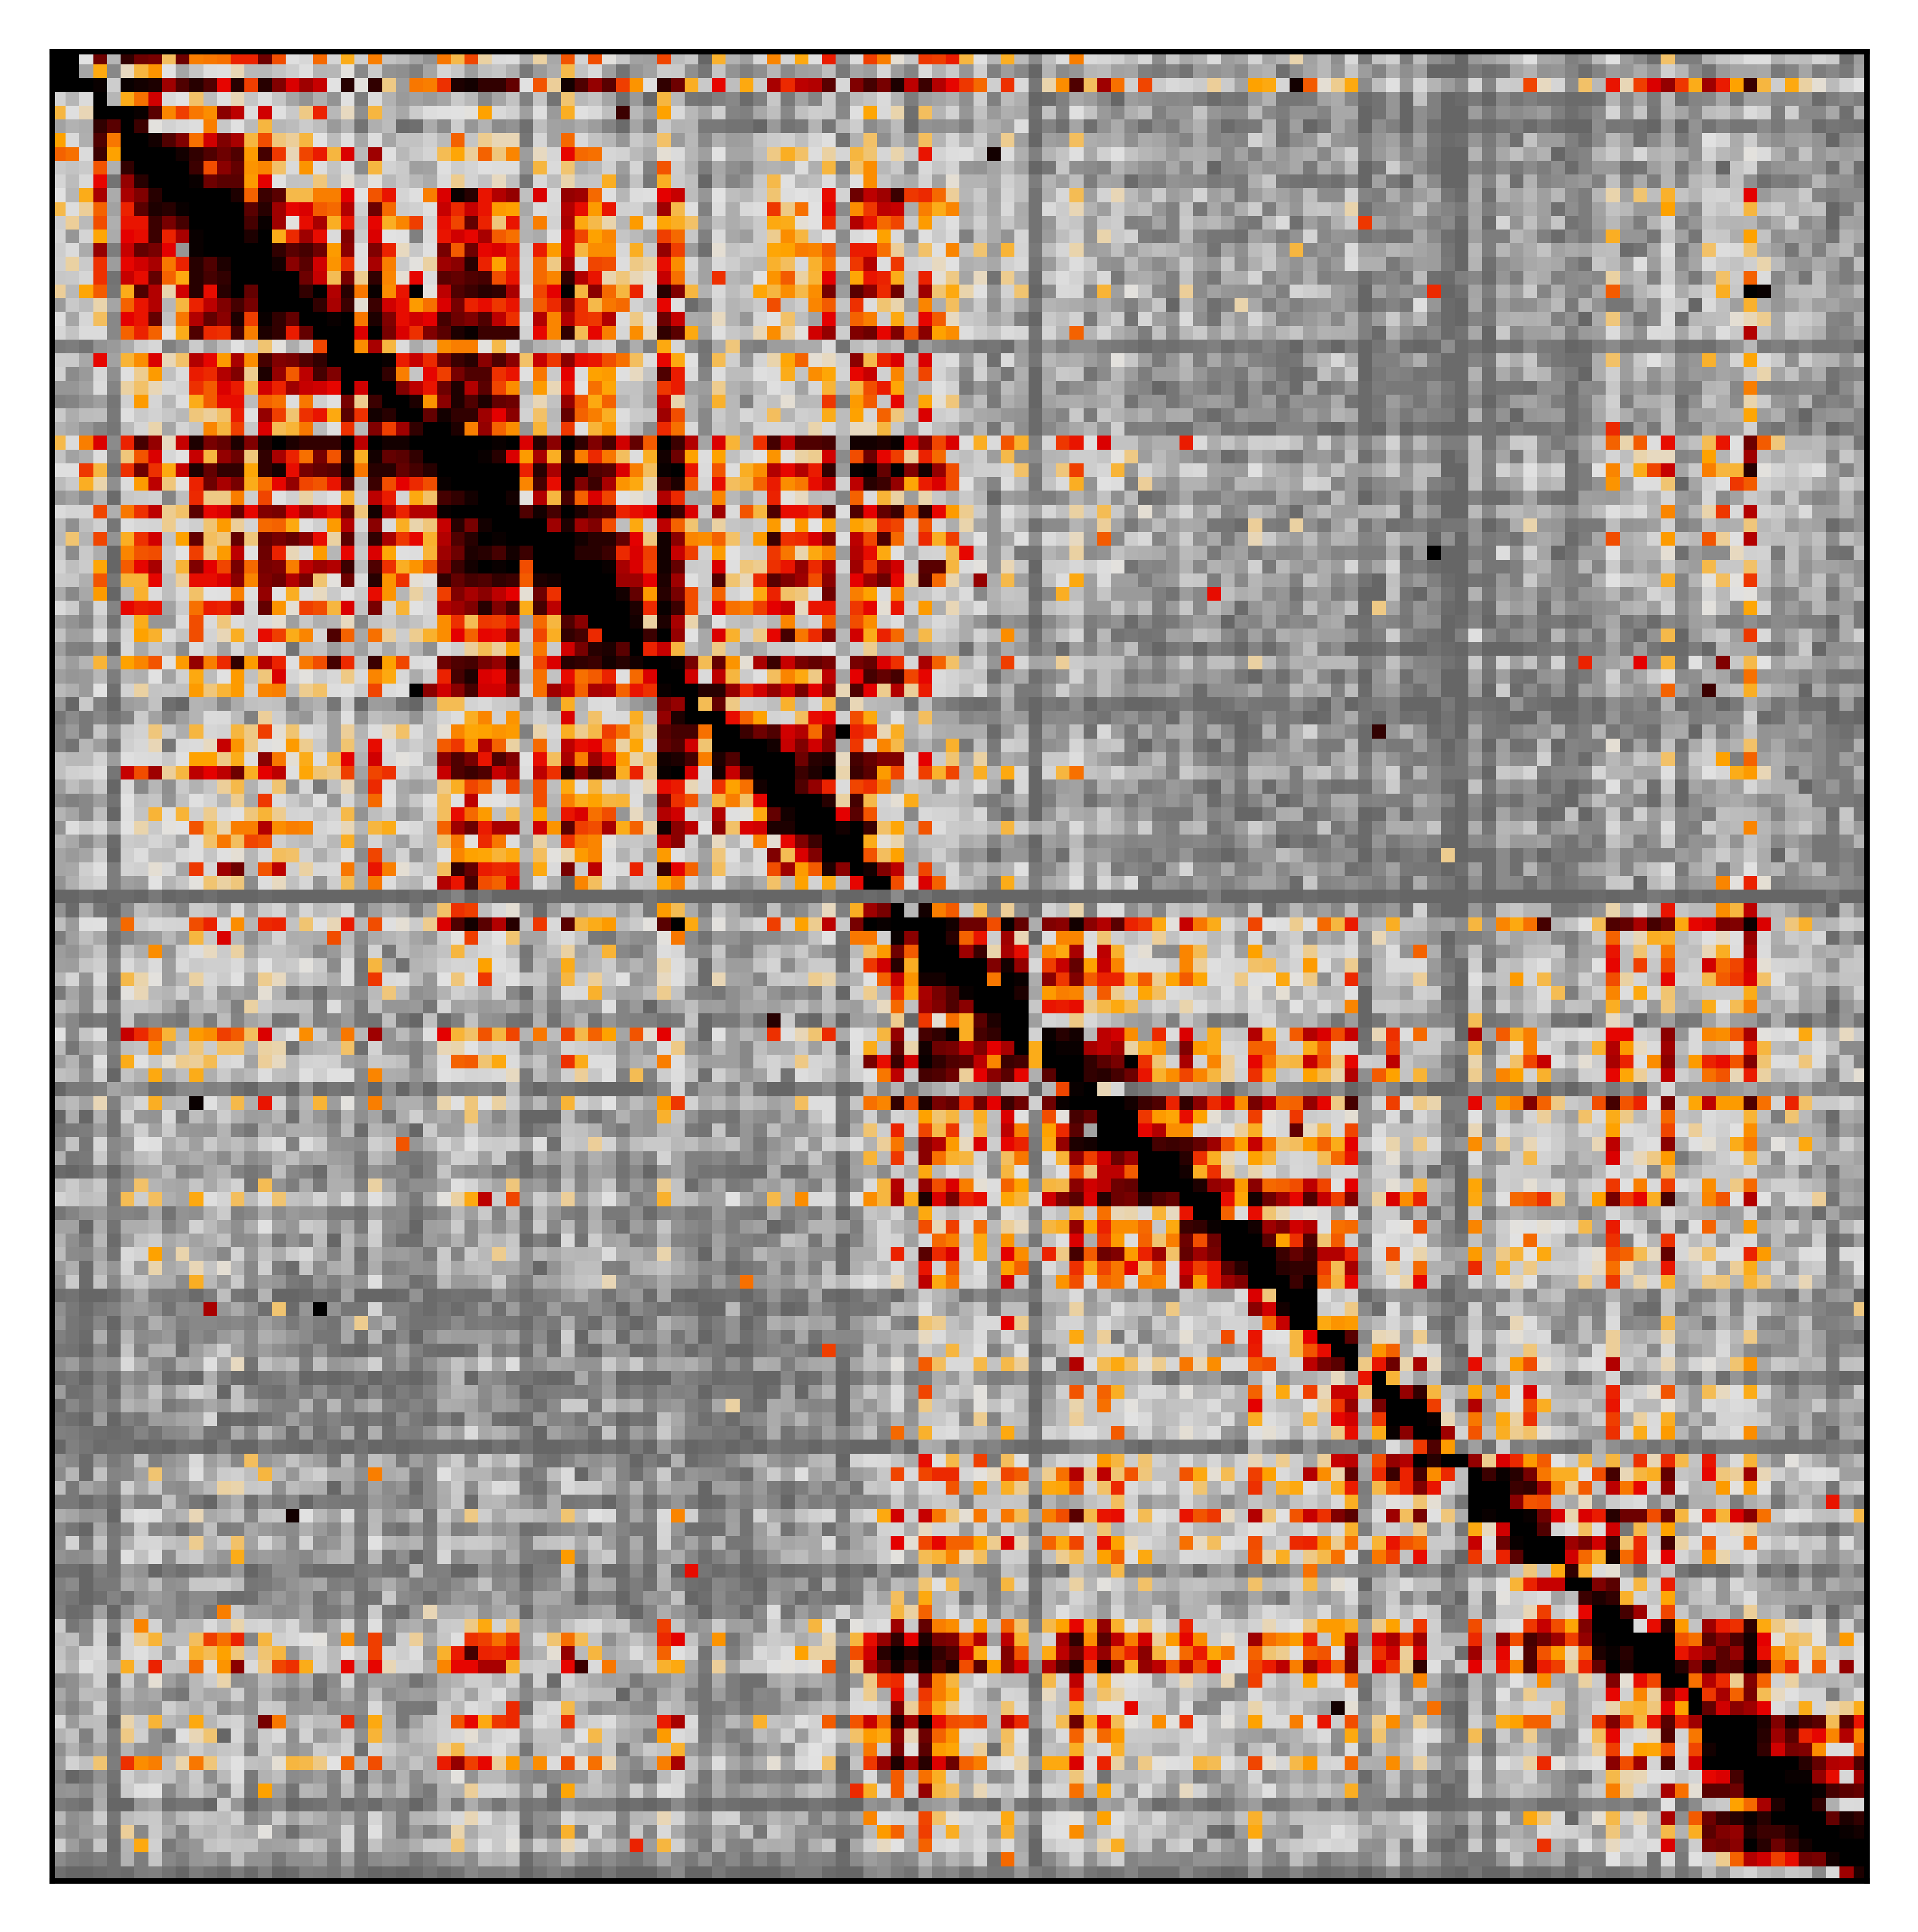

In [7]:
from IPython.display import Image
Image(filename='./raw/pNPC_Rep2_raw_Sox2.png', width=400) 

Here's the same rep and region after balancing and binning:

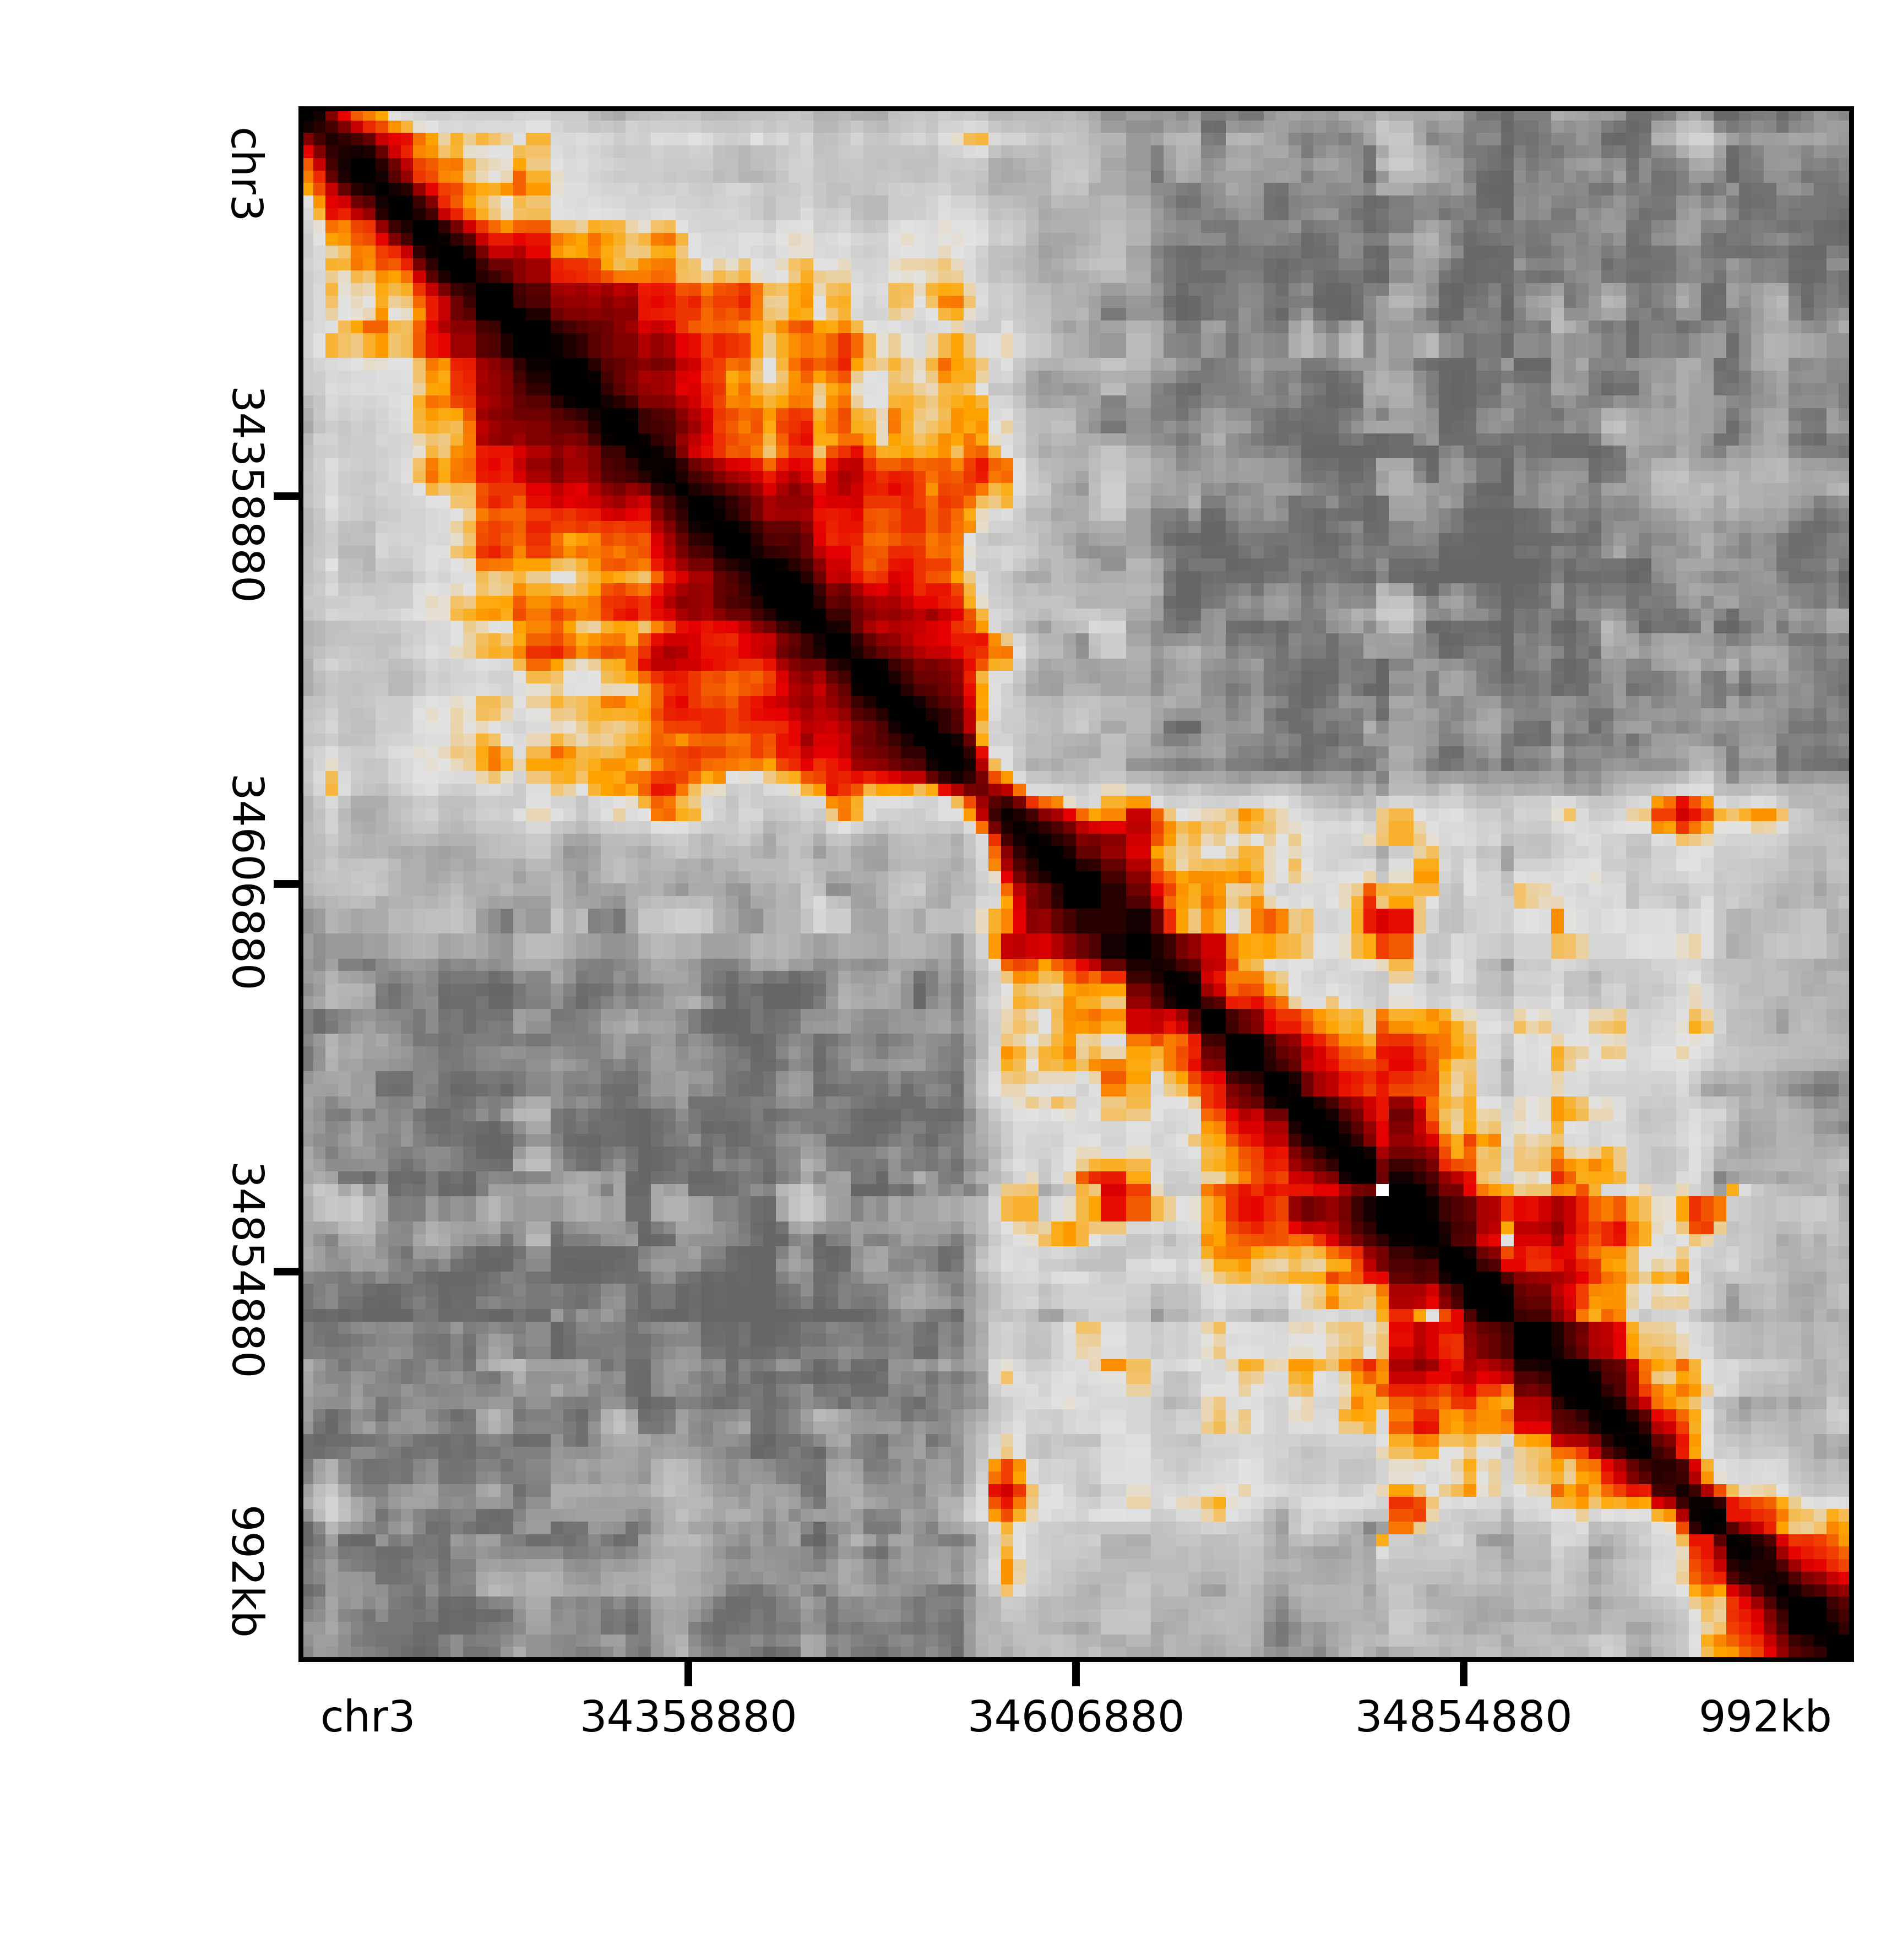

In [8]:
Image(filename='./raw/qnormed/jointexpress/bin_gmean_20_8/pNPC_Rep2_binned_Sox2.png', width=400) 

and after expected and variance modeling and p-value calling:

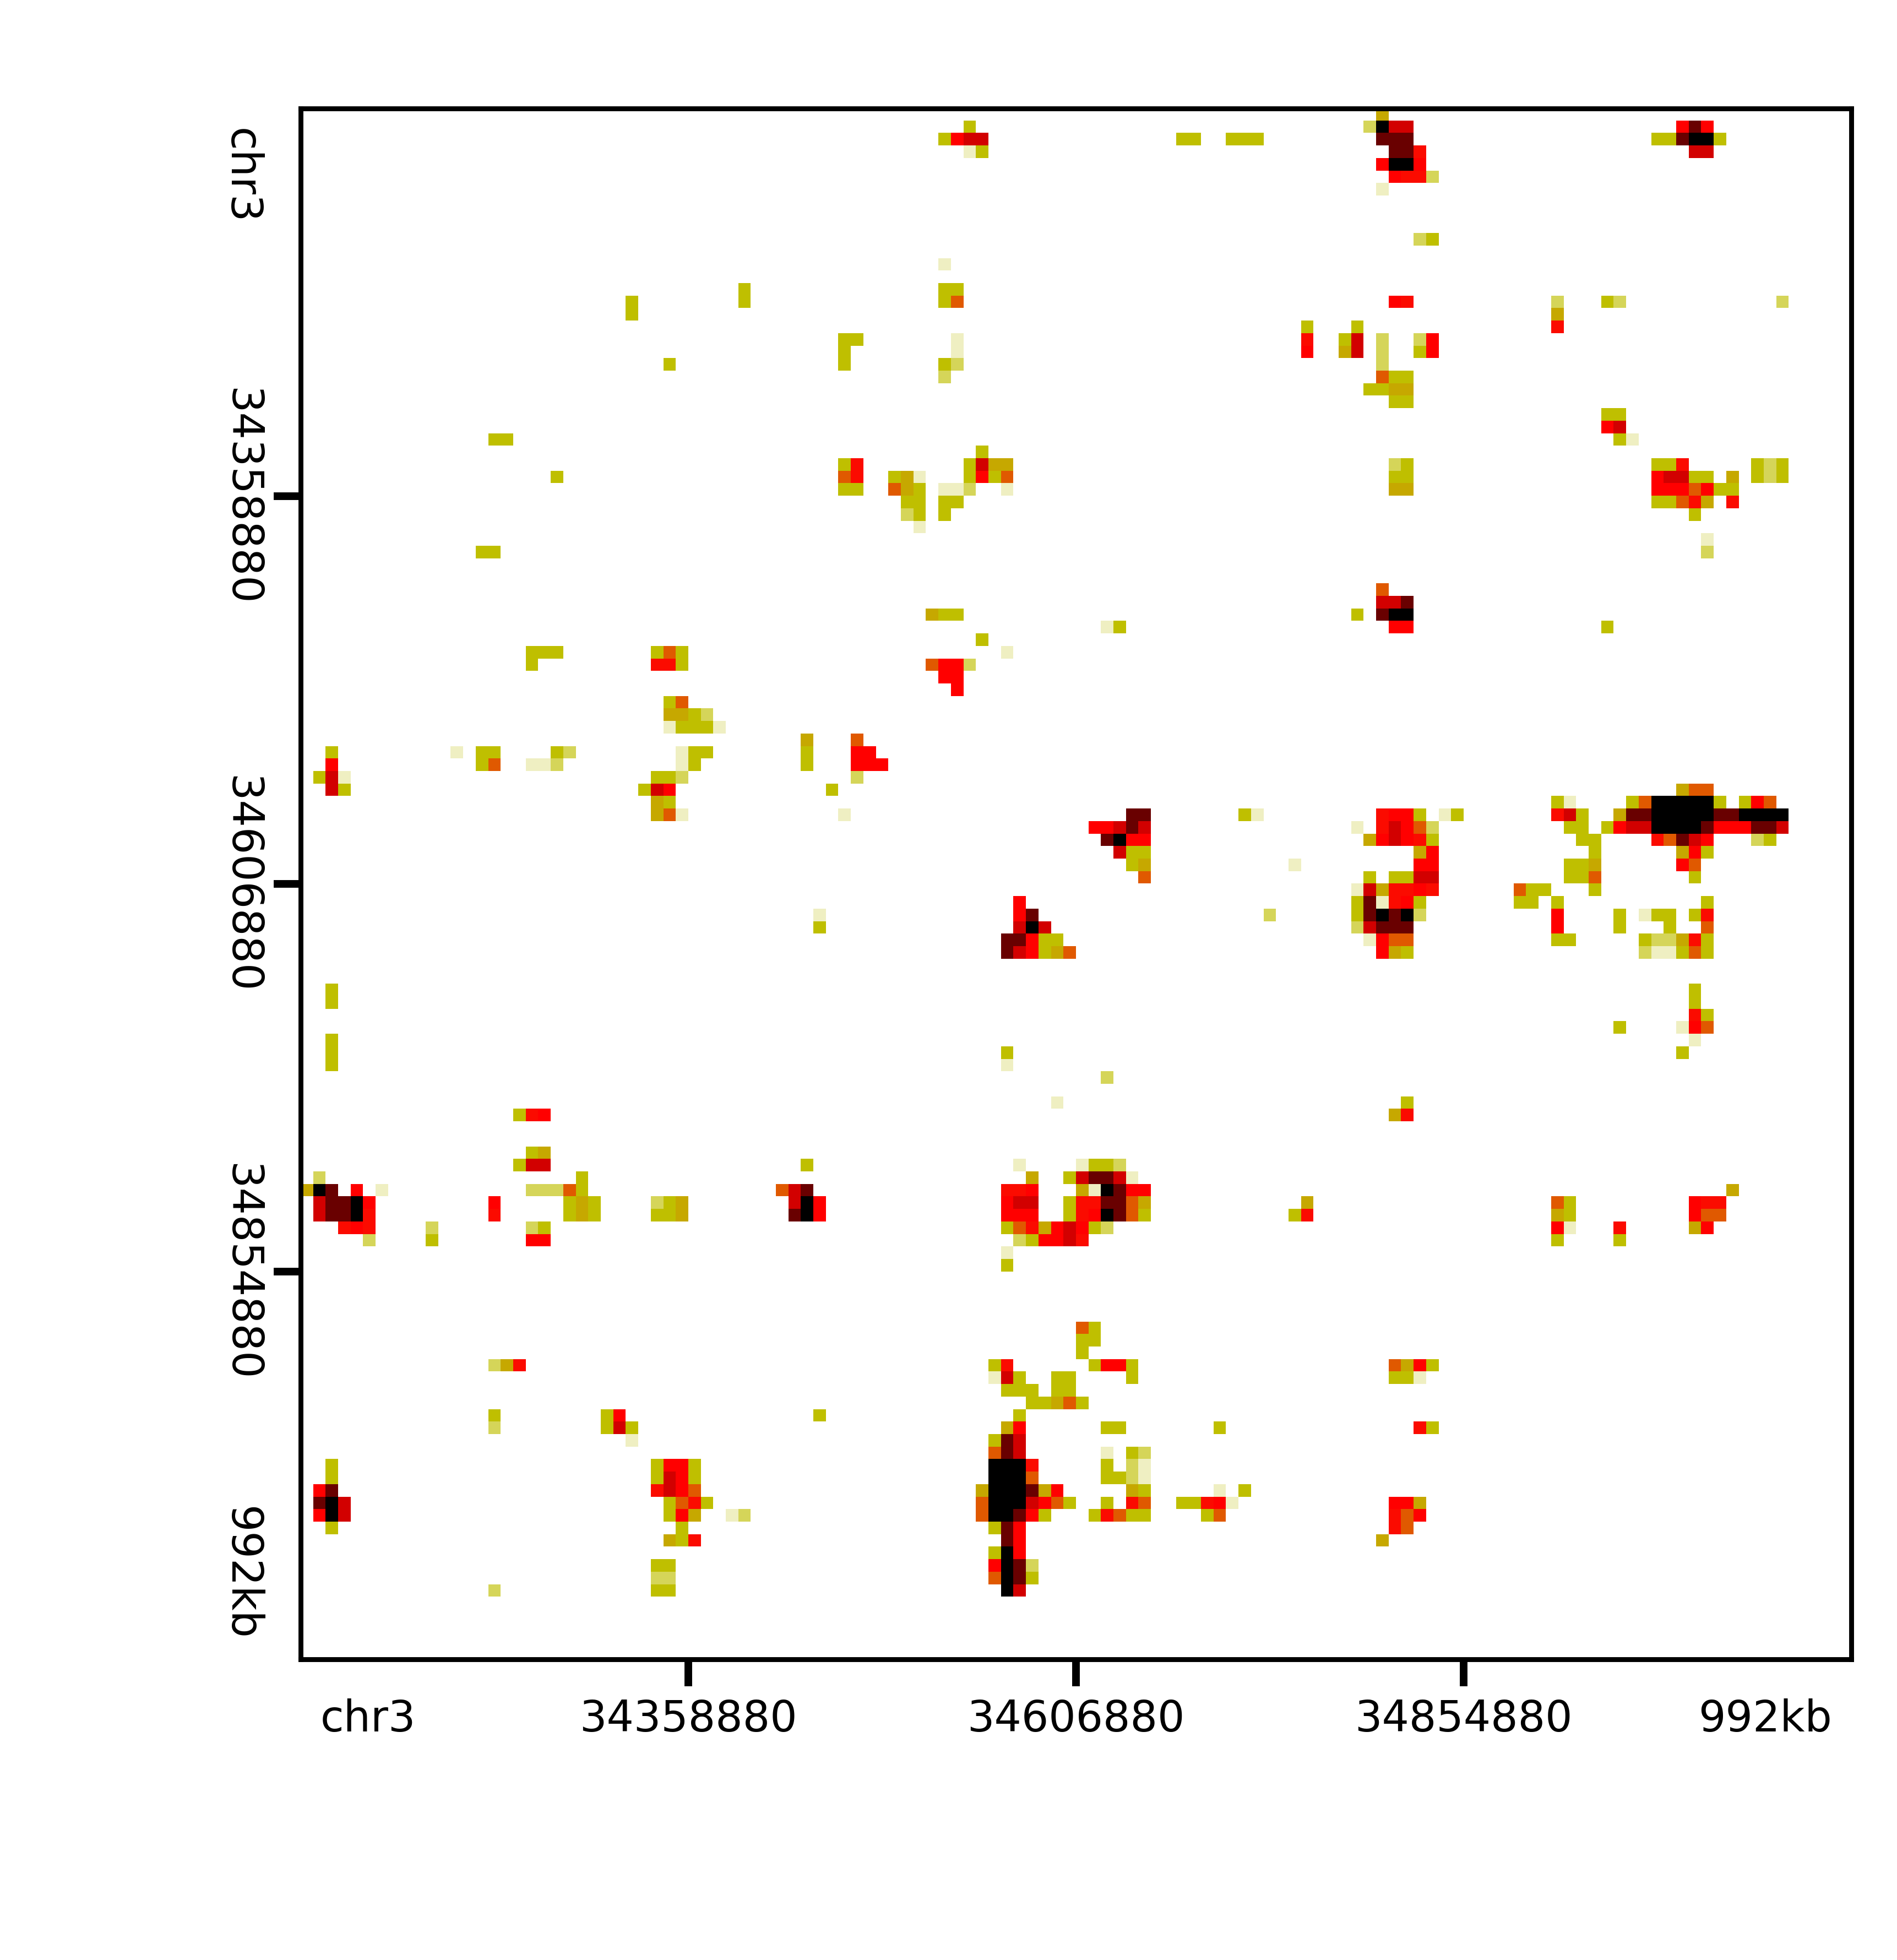

In [9]:
Image(filename='./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/pNPC_Rep2_pvalues_Sox2.png', width=400) 

Finally, here are the final condition-specific cluster calls:

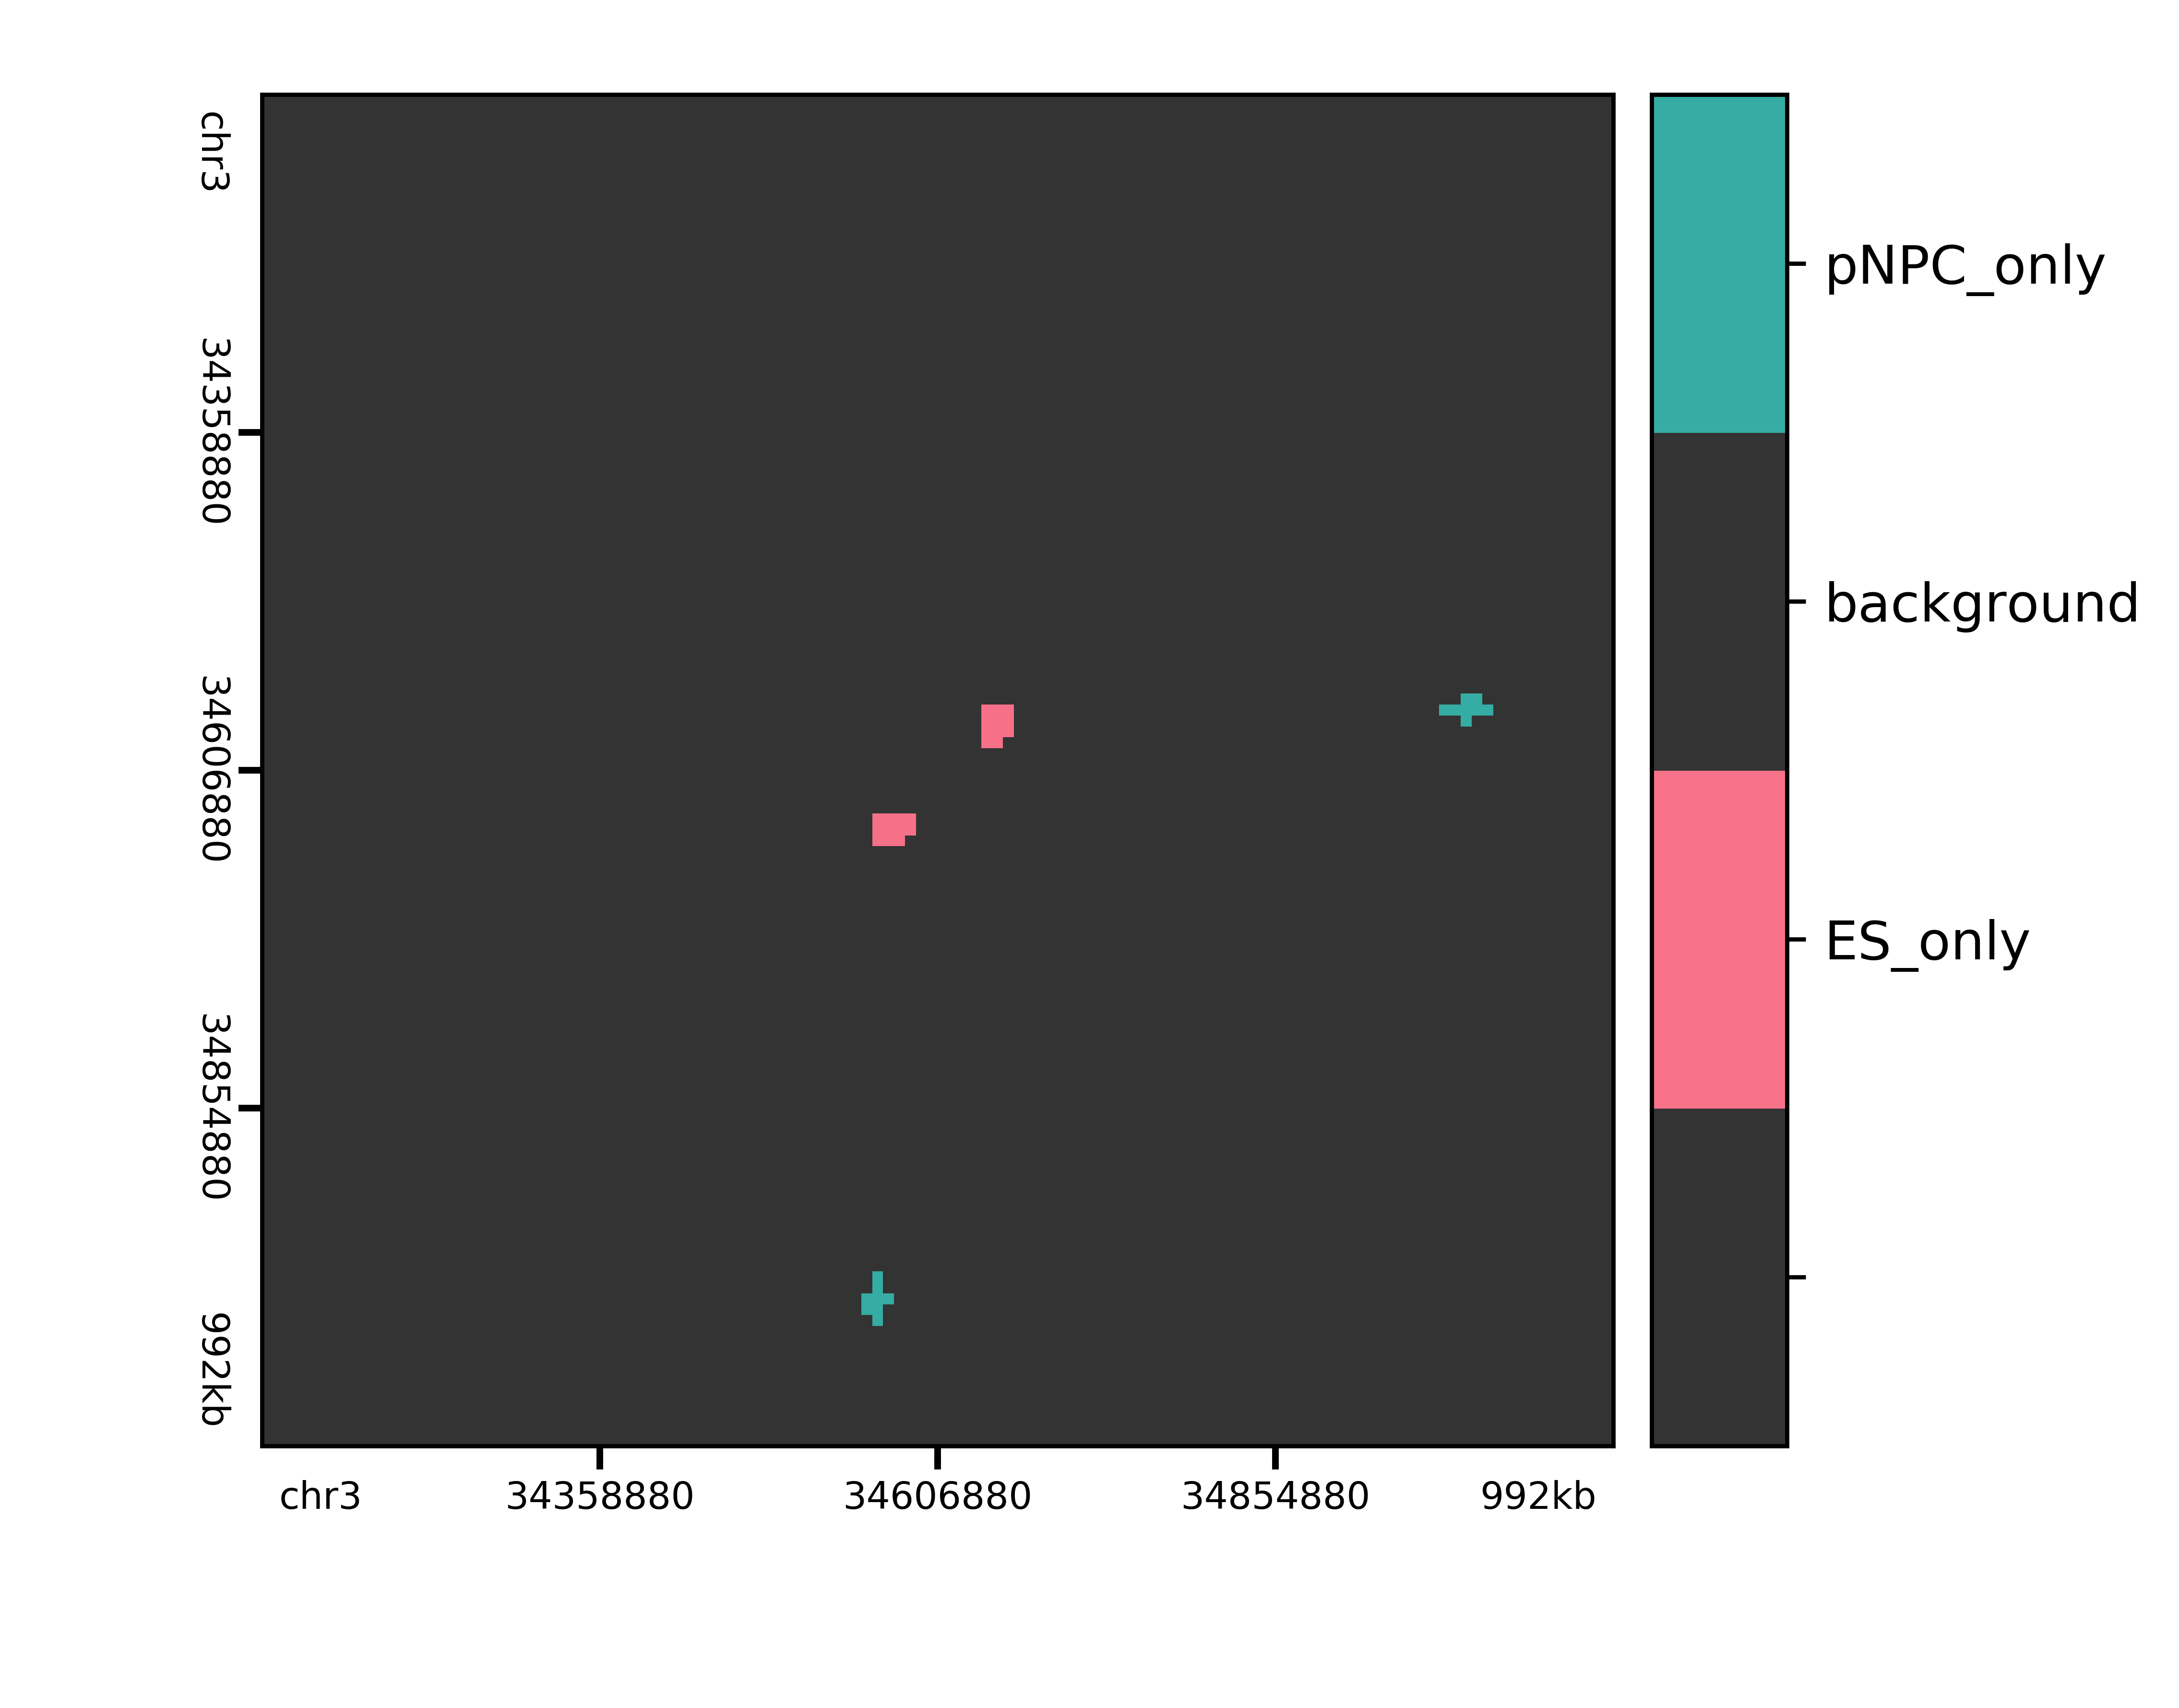

In [10]:
Image(filename='./raw/qnormed/jointexpress/bin_gmean_20_8/expected_donut/variance/pvalues/threshold/classifications_Sox2.png', width=600) 